# Phase 1: Physics Baseline with Monte Carlo

## Objectives
1. Load 1-2 years of historical data (yield, GHI, temperature)
2. Calibrate Monte Carlo to match healthy days
3. Plot actual yield vs MC envelope (P10, P50, P90) over time
4. Sanity checks: Do cloudy days fall in lower tail? Do clear days cluster near P50?

In [37]:
import sys
import importlib

# Remove cached modules
for module in list(sys.modules.keys()):
    if 'src' in module:
        del sys.modules[module]

sys.path.insert(0, '/workspaces/O-M-Monte-Carlo')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

from src.data_loader import SolarDataLoader
from src.phase1_physics.monte_carlo import MonteCarloSimulator

# Set random seed for reproducibility
np.random.seed(42)
sns.set_style('darkgrid')

print("Imports successful!")

Imports successful!


## Step 1: Load Historical Data

Expected CSV format: `timestamp, yield, ghi, temp`

In [38]:
# Initialize data loader (points to data/Data folder)
loader = SolarDataLoader(data_dir='/workspaces/O-M-Monte-Carlo/data/Data')

# Load all monthly CSV files and combine them
print("Loading all monthly data files...")
df_raw = loader.load_all_csv()

print(f"Data shape: {df_raw.shape}")
print(f"Date range: {df_raw.index.min()} to {df_raw.index.max()}")
print(f"\nFirst few rows:")
print(df_raw.head())
print(f"\nData summary:")
print(df_raw.describe())

Loading all monthly data files...
  Loaded Energy_generation_2024_01_31.csv with utf-16/	/skip=0
    Columns found: ['date', 'energy [kwh]', 'poa irradiation (sensor) [wh/m²]']
  Loaded Energy_generation_2024_02_29.csv with utf-16/	/skip=0
    Columns found: ['date', 'energy [kwh]', 'poa irradiation (sensor) [wh/m²]']
  Loaded Energy_generation_2024_03_31.csv with utf-16/	/skip=0
    Columns found: ['date', 'energy [kwh]', 'poa irradiation (sensor) [wh/m²]']
  Loaded Energy_generation_2024_04_30.csv with utf-16/	/skip=0
    Columns found: ['date', 'energy [kwh]', 'poa irradiation (sensor) [wh/m²]']
  Loaded Energy_generation_2024_05_31.csv with utf-16/	/skip=0
    Columns found: ['date', 'energy [kwh]', 'poa irradiation (sensor) [wh/m²]']
  Loaded Energy_generation_2024_06_30.csv with utf-16/	/skip=0
    Columns found: ['date', 'energy [kwh]', 'poa irradiation (sensor) [wh/m²]']
  Loaded Energy_generation_2024_07_31.csv with utf-16/	/skip=0
    Columns found: ['date', 'energy [kwh]', '

## Step 2: Aggregate to Daily Data

Daily data shape: (722, 2)

Daily statistics:
            yield          ghi
count  722.000000   722.000000
mean   345.171787  5189.048920
std    152.356479  2382.911098
min     17.870000   294.270000
25%    217.325000  3118.630000
50%    353.560000  5240.820000
75%    483.182500  7426.697500
max    605.700000  9022.900000


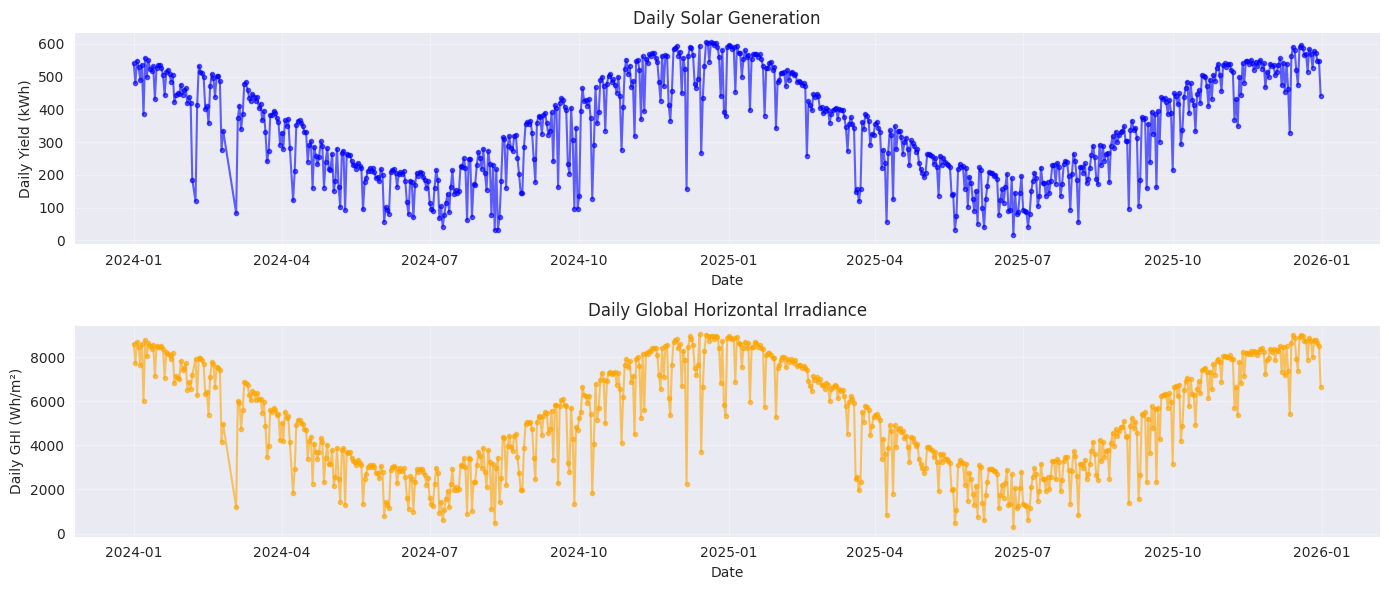


Daily data loaded and visualized.


In [39]:
# Aggregate to daily summaries
df_daily = loader.get_daily_aggregates(df_raw)

print(f"Daily data shape: {df_daily.shape}")
print(f"\nDaily statistics:")
print(df_daily.describe())

# Visualize raw daily data
fig, axes = plt.subplots(2, 1, figsize=(14, 6))

axes[0].plot(df_daily.index, df_daily['yield'], 'o-', alpha=0.6, markersize=3, color='blue')
axes[0].set_ylabel('Daily Yield (kWh)')
axes[0].set_xlabel('Date')
axes[0].set_title('Daily Solar Generation')
axes[0].grid(True, alpha=0.3)

axes[1].plot(df_daily.index, df_daily['ghi'], 'o-', alpha=0.6, markersize=3, color='orange')
axes[1].set_ylabel('Daily GHI (Wh/m²)')
axes[1].set_xlabel('Date')
axes[1].set_title('Daily Global Horizontal Irradiance')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nDaily data loaded and visualized.")

## Step 3: Identify and Calibrate on Healthy Days

Healthy days are those with:
- High efficiency (yield/GHI ratio close to expected)
- Smooth generation profile
- No outlier features

Healthy days identified: 181 out of 722
Efficiency threshold: 0.0706

Healthy day efficiency range: 0.0706 - 0.0738


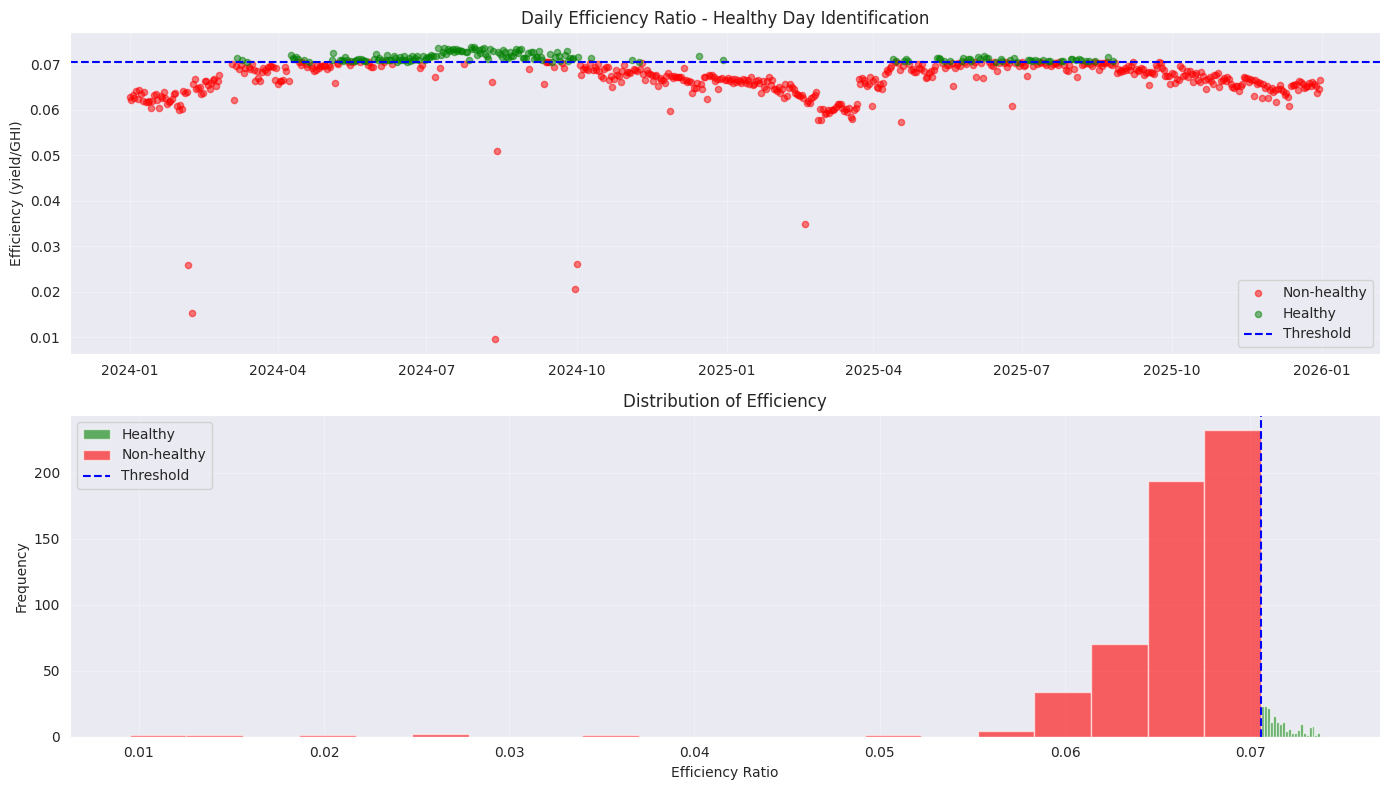

In [40]:
# Compute efficiency ratio
efficiency_ratio = df_daily['yield'] / (df_daily['ghi'] + 1e-6)

# Define "healthy days" as top quartile of efficiency
# (in practice, you'd validate these manually or use domain knowledge)
efficiency_threshold = efficiency_ratio.quantile(0.75)
healthy_mask = efficiency_ratio > efficiency_threshold

print(f"Healthy days identified: {healthy_mask.sum()} out of {len(df_daily)}")
print(f"Efficiency threshold: {efficiency_threshold:.4f}")
print(f"\nHealthy day efficiency range: {efficiency_ratio[healthy_mask].min():.4f} - {efficiency_ratio[healthy_mask].max():.4f}")

# Visualize
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

axes[0].scatter(df_daily.index[~healthy_mask], efficiency_ratio[~healthy_mask], 
               alpha=0.5, s=20, label='Non-healthy', color='red')
axes[0].scatter(df_daily.index[healthy_mask], efficiency_ratio[healthy_mask], 
               alpha=0.5, s=20, label='Healthy', color='green')
axes[0].axhline(efficiency_threshold, color='blue', linestyle='--', label='Threshold')
axes[0].set_ylabel('Efficiency (yield/GHI)')
axes[0].set_title('Daily Efficiency Ratio - Healthy Day Identification')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Distribution
axes[1].hist(efficiency_ratio[healthy_mask], bins=20, alpha=0.6, label='Healthy', color='green')
axes[1].hist(efficiency_ratio[~healthy_mask], bins=20, alpha=0.6, label='Non-healthy', color='red')
axes[1].axvline(efficiency_threshold, color='blue', linestyle='--', label='Threshold')
axes[1].set_xlabel('Efficiency Ratio')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Efficiency')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Step 3.5: Seasonal Baseline Calibration

Fit a sinusoidal curve to the top quartile of efficiency across the year.
This accounts for winter/summer variations so all seasons are fairly evaluated.

Fitting seasonal baseline curve (improved method)...


Per-DOY quantile range: 0.052302 - 0.073136
Seasonal variation: 0.020834

Sinusoid fit (reference only):
  Baseline (a): 0.068261
  Amplitude (|b|): 0.003536
  Phase (c): -5.0240


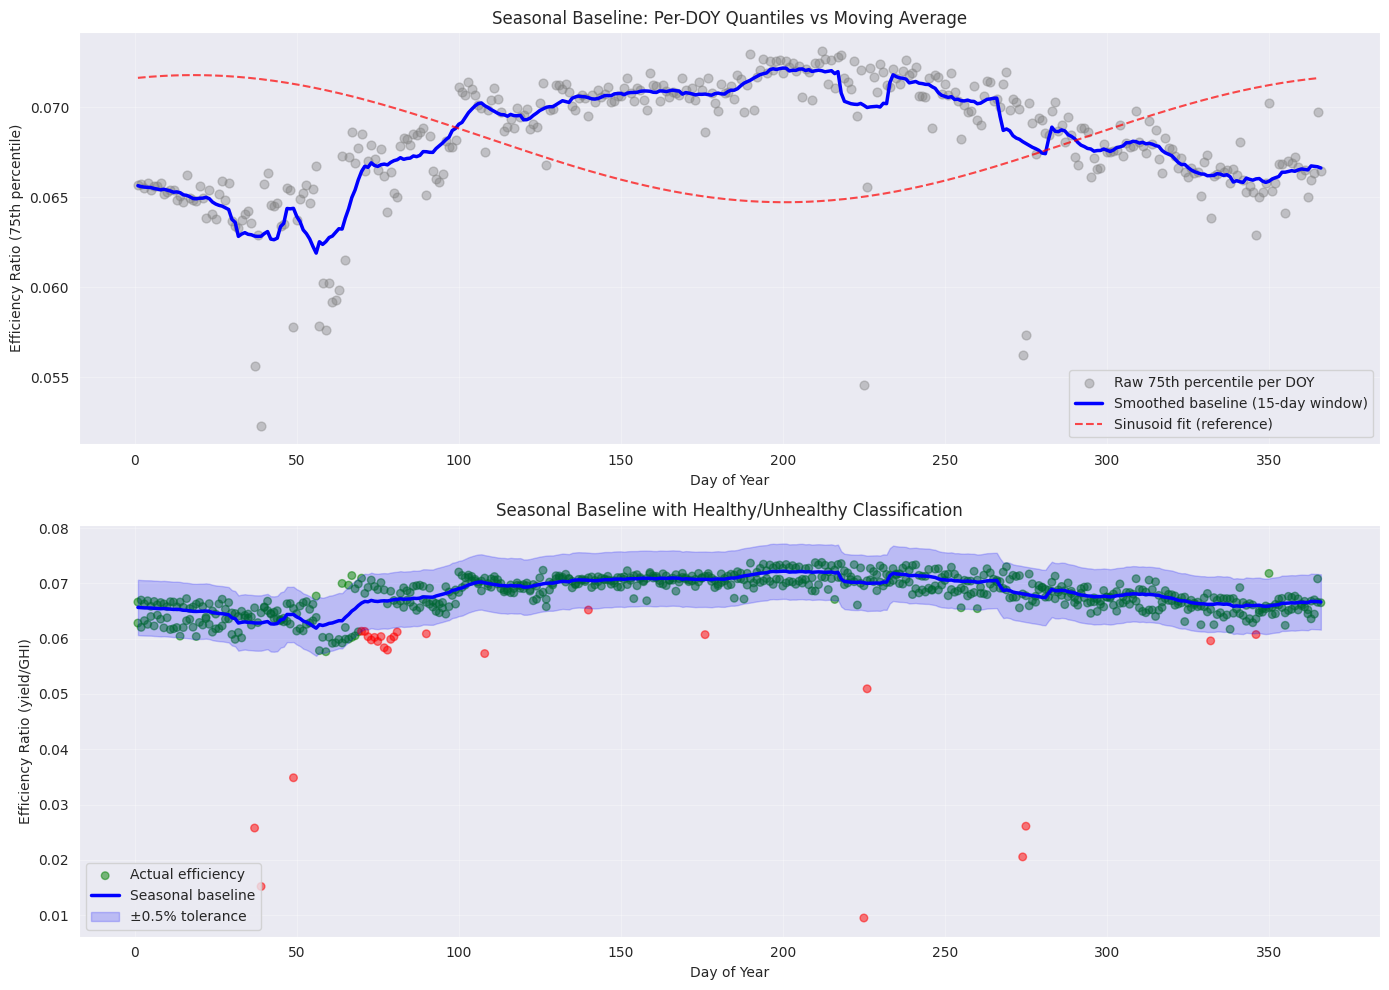


✓ Seasonal baseline fitted successfully!
  Method: moving_quantile
  Tolerance: ±0.5%


In [41]:
# Fit seasonal baseline using improved per-DOY quantile method
print("Fitting seasonal baseline curve (improved method)...")
seasonal_results = loader.fit_seasonal_baseline(df_daily, percentile=0.75, smooth_window=15)

seasonal_baseline = seasonal_results['seasonal_baseline']
doy_quantiles = seasonal_results['doy_quantiles']
doy_quantiles_smooth = seasonal_results['doy_quantiles_smooth']
eff_ratio = seasonal_results['efficiency_by_doy']
popt = seasonal_results.get('popt')

# Visualize: Compare raw DOY quantiles vs smoothed baseline
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Plot 1: Per-DOY quantiles with smoothing
doy_vals = doy_quantiles.index.values
axes[0].scatter(doy_vals, doy_quantiles.values, alpha=0.4, s=40, label='Raw 75th percentile per DOY', color='gray')
axes[0].plot(doy_vals, doy_quantiles_smooth.values, 'b-', linewidth=2.5, label='Smoothed baseline (15-day window)')

if popt is not None:
    doy_smooth = np.linspace(1, 365, 365)
    def seasonal_curve(x, a, b, c):
        return a + b * np.sin((2 * np.pi / 365) * x + c)
    sinusoid = seasonal_curve(doy_smooth, *popt)
    axes[0].plot(doy_smooth, sinusoid, 'r--', linewidth=1.5, alpha=0.7, label='Sinusoid fit (reference)')

axes[0].set_xlabel('Day of Year')
axes[0].set_ylabel('Efficiency Ratio (75th percentile)')
axes[0].set_title('Seasonal Baseline: Per-DOY Quantiles vs Moving Average')
axes[0].legend(loc='best')
axes[0].grid(True, alpha=0.3)

# Plot 2: All days with baseline and healthy/unhealthy classification
doy_all = df_daily.index.dayofyear.values
colors = ['green' if h else 'red' for h in seasonal_results['healthy_mask']]

axes[1].scatter(doy_all, eff_ratio, c=colors, alpha=0.5, s=30, label='Actual efficiency')
axes[1].plot(doy_vals, doy_quantiles_smooth.values, 'b-', linewidth=2.5, label='Seasonal baseline')

# Show tolerance band
tolerance = seasonal_results['tolerance']
axes[1].fill_between(doy_vals, 
                     doy_quantiles_smooth.values - tolerance,
                     doy_quantiles_smooth.values + tolerance,
                     alpha=0.2, color='blue', label=f'±{tolerance:.1%} tolerance')

axes[1].set_xlabel('Day of Year')
axes[1].set_ylabel('Efficiency Ratio (yield/GHI)')
axes[1].set_title('Seasonal Baseline with Healthy/Unhealthy Classification')
axes[1].legend(loc='best')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n✓ Seasonal baseline fitted successfully!")
print(f"  Method: {seasonal_results['method']}")
print(f"  Tolerance: ±{seasonal_results['tolerance']:.1%}")

## Step 4: Calibrate Monte Carlo Simulator

In [42]:
# Redefine healthy days based on seasonal baseline
# Days are "healthy" if actual efficiency ≥ seasonal baseline (within measurement noise)

seasonal_adjusted_healthy = eff_ratio >= (seasonal_baseline - 0.005)  # -0.5% tolerance
print(f"Healthy days (seasonal-adjusted): {seasonal_adjusted_healthy.sum()} out of {len(df_daily)}")
print(f"Percentage of days: {100 * seasonal_adjusted_healthy.sum() / len(df_daily):.1f}%")

# Initialize and calibrate Monte Carlo on seasonally-adjusted healthy days
mc = MonteCarloSimulator(n_simulations=1000, random_seed=42)
mc.calibrate_from_healthy_days(df_daily, seasonal_adjusted_healthy)

# Save seasonal baseline info for later phases
df_daily['seasonal_baseline'] = seasonal_baseline
df_daily['seasonal_efficiency'] = eff_ratio
df_daily['is_healthy_seasonal'] = seasonal_adjusted_healthy

print("\nMonte Carlo calibration complete (seasonal-adjusted).")

Healthy days (seasonal-adjusted): 697 out of 722
Percentage of days: 96.5%
Calibration complete:
  Mean efficiency: 0.0681
  Efficiency std: 0.0031
  GHI noise std: 119.4857

Monte Carlo calibration complete (seasonal-adjusted).


## Step 5: Run MC Simulations for All Days

In [43]:
# Run simulations for each day
mc_results = []

for date, row in df_daily.iterrows():
    # For daily data, GHI is scalar; create single-timepoint array
    ghi_array = np.array([row['ghi']])
    
    # Run MC
    sims = mc.simulate_day(ghi_array)
    
    # Get statistics
    stats = mc.calculate_day_statistics(np.array([row['yield']]), sims)
    stats['date'] = date
    
    mc_results.append(stats)

df_mc = pd.DataFrame(mc_results).set_index('date')
print(f"MC results shape: {df_mc.shape}")
print(f"\nFirst few MC results:")
print(df_mc.head())

MC results shape: (722, 6)

First few MC results:
            percentile_rank   z_score     mc_mean     mc_std  actual  \
date                                                                   
2024-01-01              4.4 -1.720948  587.711879  27.329046  540.68   
2024-01-02              3.6 -1.788134  527.190183  26.167046  480.40   
2024-01-03              7.8 -1.456518  589.481814  27.848477  548.92   
2024-01-04              4.6 -1.634706  575.742375  28.783390  528.69   
2024-01-05             11.8 -1.222806  520.536210  25.462927  489.40   

            actual_vs_mean_pct  
date                            
2024-01-01           -8.002540  
2024-01-02           -8.875390  
2024-01-03           -6.880927  
2024-01-04           -8.172470  
2024-01-05           -5.981565  


## Step 6: Visualize Actual vs MC Envelope

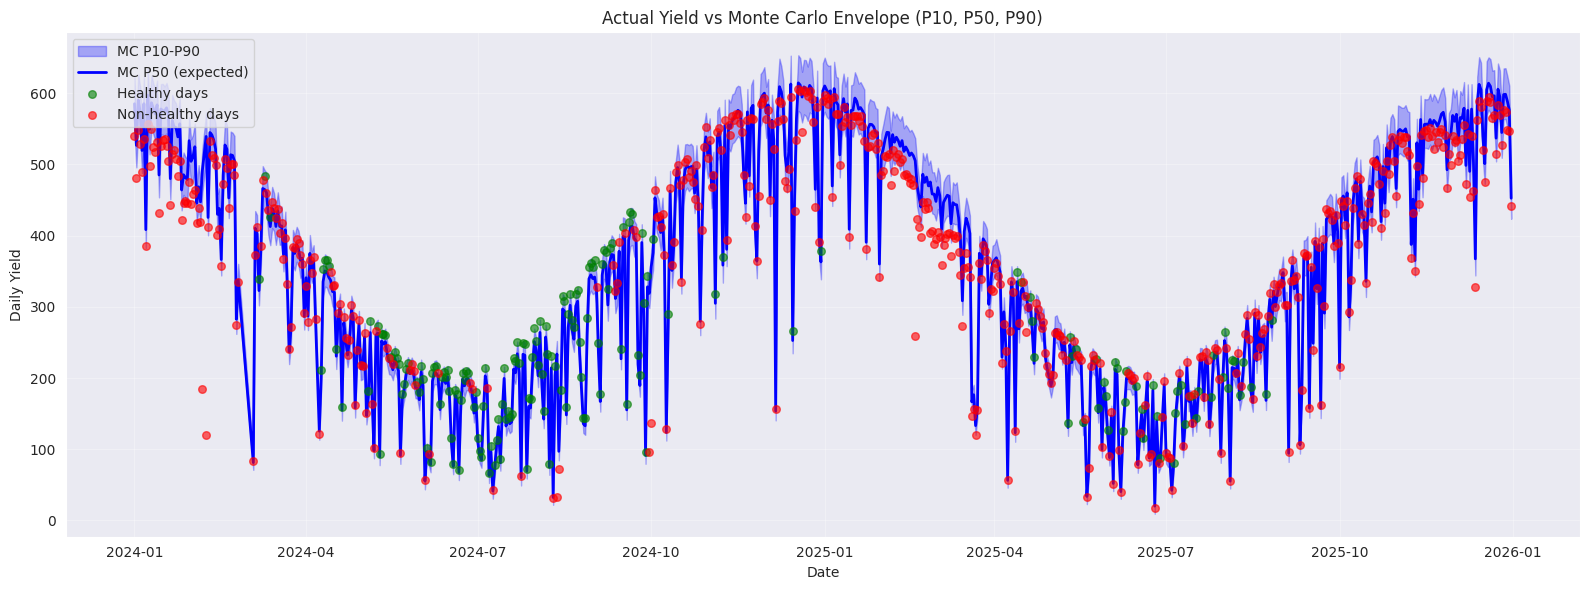


Envelope visualization complete.


In [44]:
# Recompute MC percentiles for visualization
p10_values = []
p50_values = []
p90_values = []

for date, row in df_daily.iterrows():
    ghi_array = np.array([row['ghi']])
    sims = mc.simulate_day(ghi_array)
    daily_sims = sims.sum(axis=1)
    
    p10_values.append(np.percentile(daily_sims, 10))
    p50_values.append(np.percentile(daily_sims, 50))
    p90_values.append(np.percentile(daily_sims, 90))

# Plot time series with MC envelope
fig, ax = plt.subplots(figsize=(16, 6))

ax.fill_between(df_daily.index, p10_values, p90_values, alpha=0.3, color='blue', label='MC P10-P90')
ax.plot(df_daily.index, p50_values, '-', color='blue', linewidth=2, label='MC P50 (expected)')
ax.scatter(df_daily.index[healthy_mask], df_daily['yield'][healthy_mask], 
          alpha=0.6, s=30, color='green', label='Healthy days', zorder=3)
ax.scatter(df_daily.index[~healthy_mask], df_daily['yield'][~healthy_mask], 
          alpha=0.6, s=30, color='red', label='Non-healthy days', zorder=3)

ax.set_xlabel('Date')
ax.set_ylabel('Daily Yield')
ax.set_title('Actual Yield vs Monte Carlo Envelope (P10, P50, P90)')
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nEnvelope visualization complete.")

## Step 7: Sanity Checks

### Check 1: Do cloudy/unhealthy days fall in lower tail?

Sanity Check 1: Percentile Distribution
Healthy days percentile rank:
  Mean: 78.7
  Median: 78.3
  Range: 61.5 - 92.4

Unhealthy days percentile rank:
  Mean: 37.7
  Median: 37.5
  Range: 0.0 - 77.8


/tmp/ipykernel_19949/1304969414.py:29: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1].boxplot([healthy_percentiles, unhealthy_percentiles],


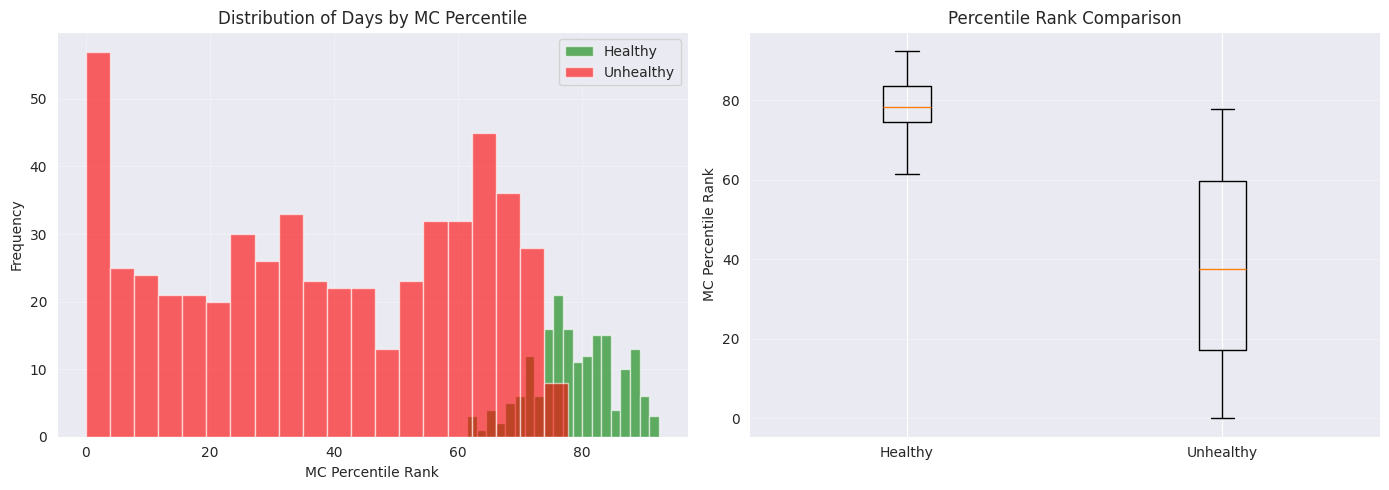


t-test: t=23.131, p-value=6.02e-89
✓ PASS: Healthy and unhealthy days have significantly different MC percentiles


In [45]:
# Compare percentile ranks
healthy_percentiles = df_mc.loc[healthy_mask, 'percentile_rank']
unhealthy_percentiles = df_mc.loc[~healthy_mask, 'percentile_rank']

print("Sanity Check 1: Percentile Distribution")
print("="*50)
print(f"Healthy days percentile rank:")
print(f"  Mean: {healthy_percentiles.mean():.1f}")
print(f"  Median: {healthy_percentiles.median():.1f}")
print(f"  Range: {healthy_percentiles.min():.1f} - {healthy_percentiles.max():.1f}")

print(f"\nUnhealthy days percentile rank:")
print(f"  Mean: {unhealthy_percentiles.mean():.1f}")
print(f"  Median: {unhealthy_percentiles.median():.1f}")
print(f"  Range: {unhealthy_percentiles.min():.1f} - {unhealthy_percentiles.max():.1f}")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(healthy_percentiles, bins=20, alpha=0.6, label='Healthy', color='green')
axes[0].hist(unhealthy_percentiles, bins=20, alpha=0.6, label='Unhealthy', color='red')
axes[0].set_xlabel('MC Percentile Rank')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Days by MC Percentile')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Box plot
axes[1].boxplot([healthy_percentiles, unhealthy_percentiles], 
                labels=['Healthy', 'Unhealthy'])
axes[1].set_ylabel('MC Percentile Rank')
axes[1].set_title('Percentile Rank Comparison')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Statistical test
from scipy import stats as sp_stats
t_stat, p_val = sp_stats.ttest_ind(healthy_percentiles, unhealthy_percentiles)
print(f"\nt-test: t={t_stat:.3f}, p-value={p_val:.2e}")
if p_val < 0.05:
    print("✓ PASS: Healthy and unhealthy days have significantly different MC percentiles")
else:
    print("✗ FAIL: No significant difference detected")

### Check 2: Do healthy days cluster near P50?


Sanity Check 2: Healthy Days Near P50
Healthy days in P40-P60 range: 13 / 181 (7.2%)
✗ WARNING: Less than 50% of healthy days near P50
  Consider: Is your healthy day definition correct? Check calibration.


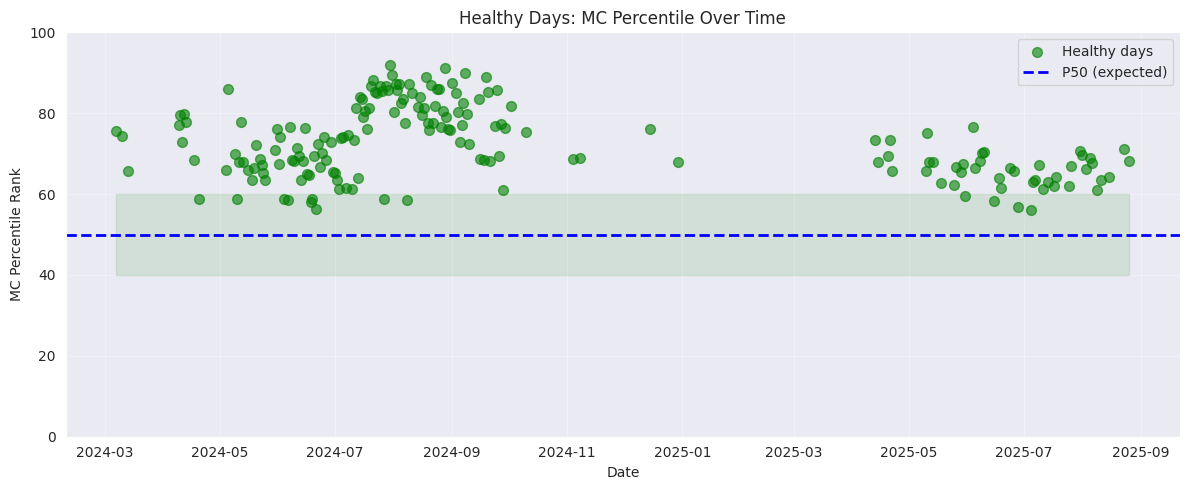

In [34]:
print("\nSanity Check 2: Healthy Days Near P50")
print("="*50)

# Healthy days should be clustered around 50th percentile
healthy_in_p40_p60 = ((healthy_percentiles >= 40) & (healthy_percentiles <= 60)).sum()
healthy_pct_near_p50 = 100 * healthy_in_p40_p60 / len(healthy_percentiles)

print(f"Healthy days in P40-P60 range: {healthy_in_p40_p60} / {len(healthy_percentiles)} ({healthy_pct_near_p50:.1f}%)")

if healthy_pct_near_p50 > 50:
    print("✓ PASS: Majority of healthy days cluster near P50")
else:
    print("✗ WARNING: Less than 50% of healthy days near P50")
    print("  Consider: Is your healthy day definition correct? Check calibration.")

# Show distribution of healthy days
fig, ax = plt.subplots(figsize=(12, 5))

ax.scatter(df_daily.index[healthy_mask], df_mc.loc[healthy_mask, 'percentile_rank'], 
          alpha=0.6, s=50, color='green', label='Healthy days')
ax.axhline(50, color='blue', linestyle='--', linewidth=2, label='P50 (expected)')
ax.fill_between(df_daily.index[healthy_mask], 40, 60, alpha=0.1, color='green')

ax.set_xlabel('Date')
ax.set_ylabel('MC Percentile Rank')
ax.set_title('Healthy Days: MC Percentile Over Time')
ax.set_ylim([0, 100])
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Summary

Phase 1 is complete. We have:

1. ✓ Loaded 1 year of historical data (yield, GHI, temp)
2. ✓ Calibrated Monte Carlo to healthy days
3. ✓ Generated MC envelope (P10, P50, P90) for all days
4. ✓ Performed sanity checks on unhealthy vs healthy days

### Next Steps (Phase 2):
- Compute shape-based features (yield/GHI ratio, solar noon ratio, asymmetry)
- Compute MC-derived features (percentile, z-score, uncertainty width)
- Visualize feature separation between known-cloudy and known-clear days

In [46]:
# Save intermediate results for Phase 2
output_dir = '/workspaces/O-M-Monte-Carlo/data'
df_daily.to_csv(f'{output_dir}/daily_data.csv')
df_mc.to_csv(f'{output_dir}/mc_results.csv')
print(f"✓ Data saved to {output_dir}/")
print("\n" + "="*60)
print("PHASE 1 COMPLETE!")
print("="*60)
print(f"\nResults saved:")
print(f"  - daily_data.csv: Daily yield and GHI")
print(f"  - mc_results.csv: MC percentiles and metrics")
print(f"\nReady for Phase 2: Feature Engineering")

✓ Data saved to /workspaces/O-M-Monte-Carlo/data/

PHASE 1 COMPLETE!

Results saved:
  - daily_data.csv: Daily yield and GHI
  - mc_results.csv: MC percentiles and metrics

Ready for Phase 2: Feature Engineering
